In [1]:
%load_ext autoreload
%autoreload 2

from spelke_net.predictor.flow_predictor import LRASFlowPredictor
import h5py as h5
from spelke_net.utils.camera import pose_list_to_matrix
from spelke_net.utils.flow import flow_to_image
import matplotlib.pyplot as plt
import torch
import numpy as np
from spelke_net.utils.segment import plot_expected_displacement_map, plot_image_with_virtual_poke

## 📦 Load SpelkeNet Model 

In [2]:
model_name = 'SpelkeNet7B.pt'
device = 'cuda:4'

predictor = LRASFlowPredictor(
        model_name, 'rgb_quantizer.pt', 'flow_quantizer.pt', device=device
    )

Loading model from /ccn2/u/rmvenkat/code/deploy_code/SpelkeNet/out/SpelkeNet7B.pt
|-------------------------------------------------|
|         ✨ Model Information Overview ✨        |
|-------------------------------------------------|
| 📦 Model Name:                                  |
| SpelkeNet7B.pt                                  |
|-------------------------------------------------|
| 📂 Model loaded from:                           |
| /ccn2/u/rmvenkat/code/deploy_code/SpelkeNet/out |
|-------------------------------------------------|
| 🔢 7357.1M parameters in the model              |
|-------------------------------------------------|
Loading model from /ccn2/u/rmvenkat/code/deploy_code/SpelkeNet/out/rgb_quantizer.pt
|-------------------------------------------------|
|         ✨ Model Information Overview ✨        |
|-------------------------------------------------|
| 📦 Model Name:                                  |
| rgb_quantizer.pt                                |
|---------

## 🖼️ Load Input Image ##

Text(0.5, 1.0, 'Input image')

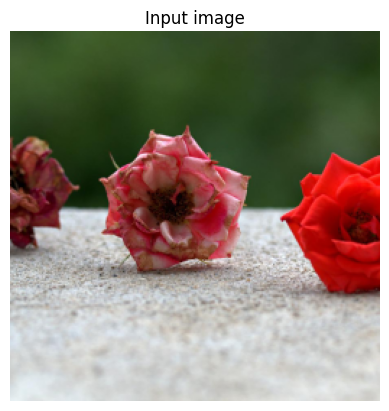

In [3]:
img = plt.imread('../demo_images/rose.png')[:, :, :3]
plt.imshow(img)
plt.axis('off')
plt.title('Input image')

## 🎥 Fix the camera

In [4]:
#set camera motion to zero: we want to understand the what parts of the scene will move upon external forces, independent of camera motion
campose = pose_list_to_matrix([0.0]*6)

#set the motion of the four corner to 0 to further refinforce a fixed camera
flow_cond = [[248,0,248,0],[0,0,0,0],[0,248,0,248],[248,248,248,248]]

## 🤏 Apply virtual poke

In [5]:
#prepare flow input
flow_cond_poke = [[128,128,138,128]]

combined_flow = flow_cond + flow_cond_poke

#get prediction in parallel mode
predictions = predictor.quantized_flow_prediction(
        img,
        campose=campose,
        flow_cond=combined_flow,
        num_seq_patches=0,
        mode="seq2par", 
        seed=0, 
        mask_out=True,
    )

unmask_indices [31, 0, 992, 1023, 528]


/ccn2/u/rmvenkat/code/deploy_code/SpelkeNet/spelke_net/predictor/flow_predictor.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torchvision.transforms.Lambda(lambda x: torch.tensor(x).permute(2,0,1) if len(x.shape) == 3 else torch.tensor(x).permute(0,3,1,2)),


## 🗝️ Flow token epigraphy

In [6]:
#load the mapping between the flow token and flows using the flow token epigraphy procedure described in Sec 3.2 
token_to_flow_mapping = predictor.token_to_flow_dict 

## 📈 Expected displacement map using the predicted flow distributions (parallel)

In [7]:
from spelke_net.utils.segment import compute_avg_flow_from_logits

#range of flow tokens in the unified vocabulary
start, end = predictor.model.config.flow_range

logits = predictions["flow_logits"]

parallel_flow_pred, flow_img = compute_avg_flow_from_logits(logits, start, end,
                                                            token_to_flow_dict=token_to_flow_mapping)


## 🔍 Visualize Expected Displacement (Parallel)

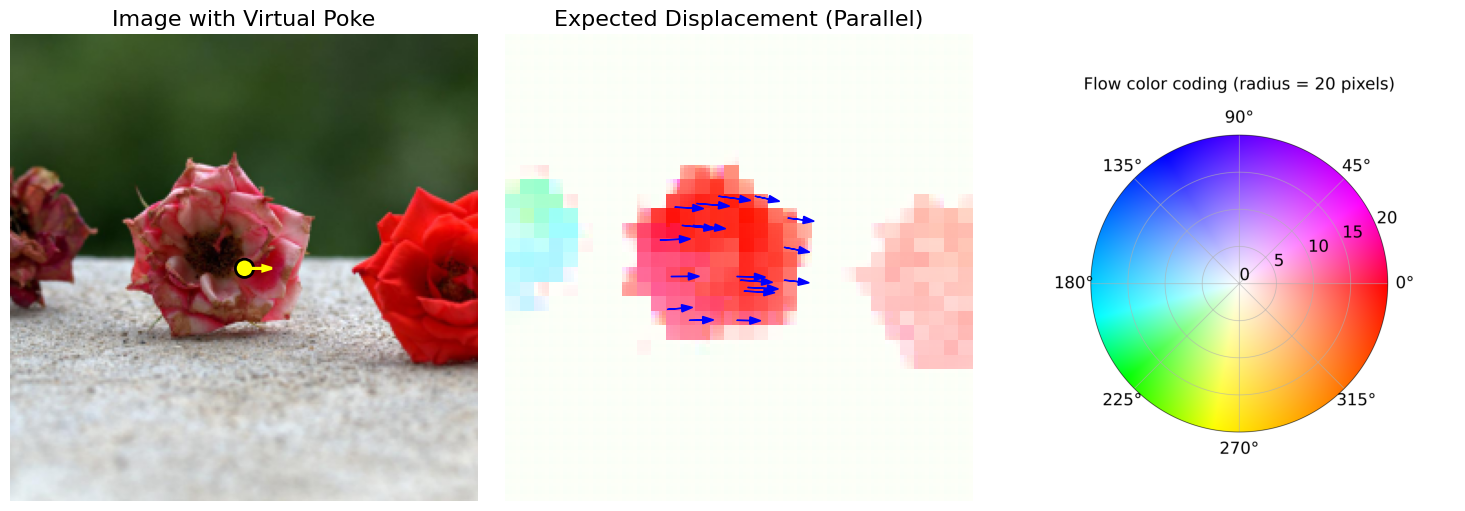

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Read the image
flow_color_wheel = plt.imread('../demo_images/flow_color_wheel.png')

# Add white padding around the image (pad with 1s for white if image is float32 RGB)
pad_frac = 0.10  # 50% padding on each side
h, w, c = flow_color_wheel.shape
pad_h = int(h * pad_frac)
pad_w = int(w * pad_frac)

# Pad with white (1.0 for float images)
padded_wheel = np.pad(flow_color_wheel, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant', constant_values=1.0)

# Create the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image with poke
axes[0] = plot_image_with_virtual_poke(axes[0], img, flow_cond_poke[0])
axes[0].axis('off')
axes[0].set_title("Image with Virtual Poke", fontsize=16)


# Flow image with arrows
axes[1].imshow(flow_img)
axes[1] = plot_expected_displacement_map(axes[1], parallel_flow_pred)
axes[1].axis('off')
axes[1].set_title("Expected Displacement (Parallel)", fontsize=16)

# Show padded flow color wheel
axes[2].imshow(padded_wheel)
axes[2].axis('off')

plt.tight_layout()
plt.show()


## 📈 Expected displacement map using the predicted flows (sequential)

In [9]:
#prepare flow input
flow_cond_poke = [[128,128,138,128]]

combined_flow = flow_cond + flow_cond_poke
num_runs = 8
N_seq = 32

all_flows = []
#predict N_seq flow tokens in sequence and remaining in parallel, and repeat this num_runs times over different seeds
for seed in range(num_runs):
    
    predictions = predictor.quantized_flow_prediction(
            img,
            campose=campose,
            flow_cond=combined_flow,
            num_seq_patches=N_seq,
            mode="seq2par", 
            seed=seed, 
            mask_out=True,
        )
    
    all_flows.append(predictions["flow_pred_np"])

expected_displacement_sequential = np.mean(np.stack(all_flows, 0), 0)

flow_img = flow_to_image(expected_displacement_sequential)

unmask_indices [31, 0, 992, 1023, 528]


Rolling out sequence: 100%|█| 160/160 [00:12<00:00, 12.90it/s]


unmask_indices [31, 0, 992, 1023, 528]


Rolling out sequence: 100%|█| 160/160 [00:09<00:00, 16.63it/s]


unmask_indices [31, 0, 992, 1023, 528]


Rolling out sequence: 100%|█| 160/160 [00:09<00:00, 16.63it/s]


unmask_indices [31, 0, 992, 1023, 528]


Rolling out sequence: 100%|█| 160/160 [00:09<00:00, 16.62it/s]


unmask_indices [31, 0, 992, 1023, 528]


Rolling out sequence: 100%|█| 160/160 [00:09<00:00, 16.67it/s]


unmask_indices [31, 0, 992, 1023, 528]


Rolling out sequence: 100%|█| 160/160 [00:09<00:00, 16.57it/s]


unmask_indices [31, 0, 992, 1023, 528]


Rolling out sequence: 100%|█| 160/160 [00:09<00:00, 16.60it/s]


unmask_indices [31, 0, 992, 1023, 528]


Rolling out sequence: 100%|█| 160/160 [00:09<00:00, 16.63it/s]


## 🔍 Visualize Expected Displacement (Sequential)

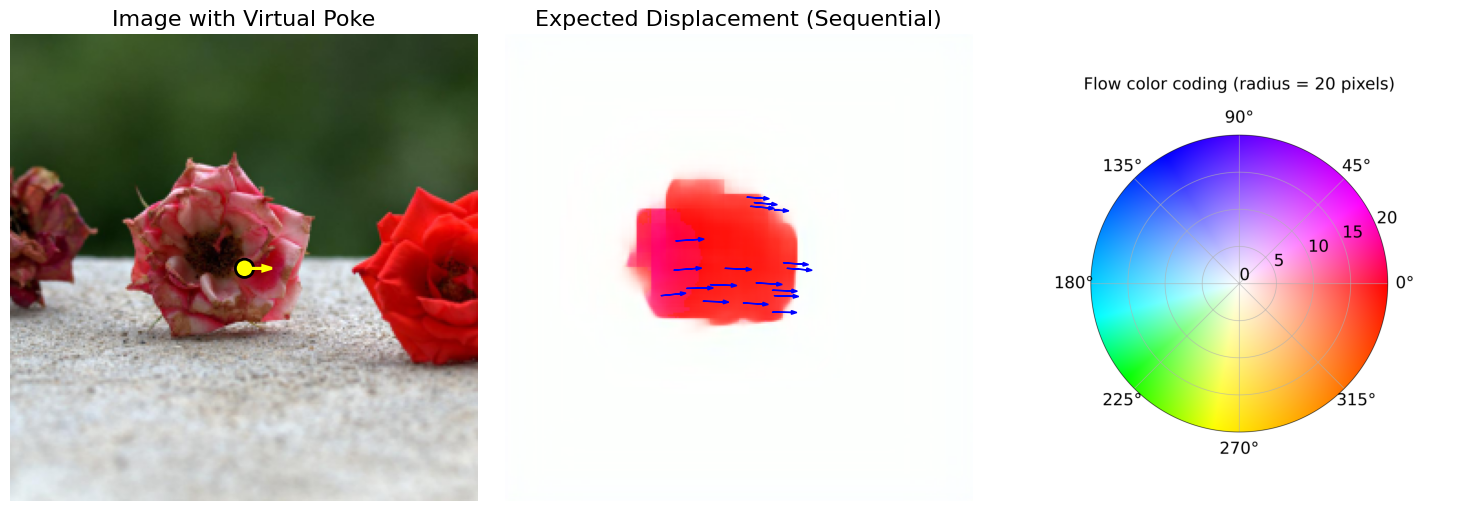

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Read the image
flow_color_wheel = plt.imread('../demo_images/flow_color_wheel.png')

# Add white padding around the image (pad with 1s for white if image is float32 RGB)
pad_frac = 0.10  # 50% padding on each side
h, w, c = flow_color_wheel.shape
pad_h = int(h * pad_frac)
pad_w = int(w * pad_frac)

# Pad with white (1.0 for float images)
padded_wheel = np.pad(flow_color_wheel, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='constant', constant_values=1.0)

# Create the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image with poke
axes[0] = plot_image_with_virtual_poke(axes[0], img, flow_cond_poke[0])
axes[0].axis('off')
axes[0].set_title("Image with Virtual Poke", fontsize=16)

# Flow image with arrows
axes[1].imshow(flow_img)
axes[1] = plot_expected_displacement_map(axes[1], expected_displacement_sequential)
axes[1].axis('off')
axes[1].set_title("Expected Displacement (Sequential)", fontsize=16)

# Show padded flow color wheel
axes[2].imshow(padded_wheel)
axes[2].axis('off')

plt.tight_layout()
plt.show()
